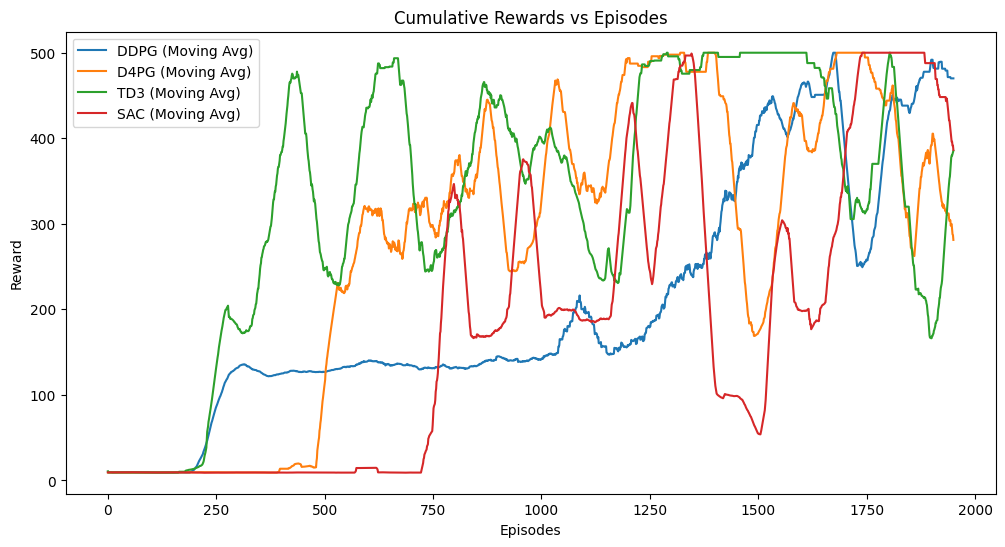

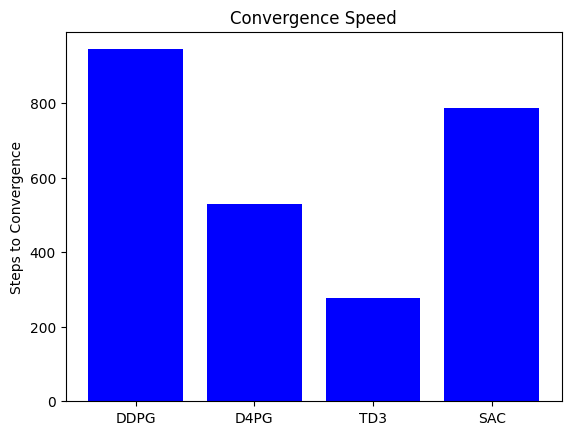

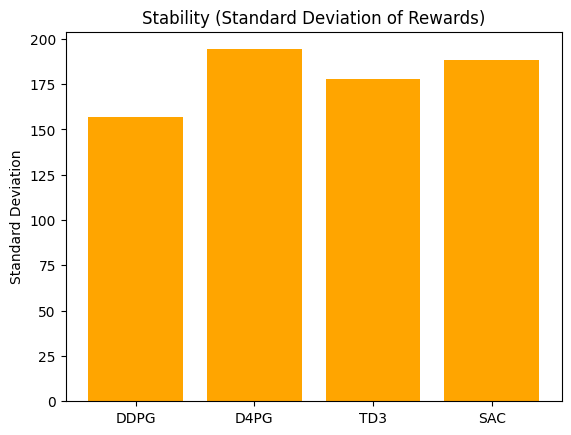

In [4]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# Custom wrapper for continuous CartPole
class ContinuousCartPoleWrapper(gym.Env):
    def __init__(self, env):
        self.env = env
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = self.env.observation_space

    def step(self, action):
        # Map continuous action to discrete action
        discrete_action = 0 if action[0] < 0.5 else 1
        obs, reward, done, info = self.env.step(discrete_action)
        return obs, reward, done, info

    def reset(self):
        return self.env.reset()

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()


# Define the Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Sigmoid(),  # Logistic output
        )

    def forward(self, state):
        return self.net(state)


# Define the Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(np.array(states), dtype=torch.float32),  # Ensure states are 2D
            torch.tensor(np.array(actions), dtype=torch.float32).squeeze(1),  # Ensure actions are 2D
            torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(1),
            torch.tensor(np.array(next_states), dtype=torch.float32),
            torch.tensor(np.array(dones), dtype=torch.float32).unsqueeze(1),
        )

    def size(self):
        return len(self.buffer)


def train_rl_algorithm(algorithm, env, actor, critic, target_actor, target_critic, buffer, actor_optimizer,
                       critic_optimizer, n_episodes=500, batch_size=64, gamma=0.99, tau=0.005, reward_threshold=300):
    rewards = []
    steps_to_convergence = None

    for episode in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        while True:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # 2D input for actor
            action = actor(state_tensor).detach().numpy()[0]
            next_state, reward, done, _ = env.step([action])  # Wrap action in a list for compatibility
            buffer.add((state, [action], reward, next_state, done))

            if buffer.size() > batch_size:
                states, actions, rewards_batch, next_states, dones = buffer.sample(batch_size)

                # Update Critic
                target_actions = target_actor(next_states)
                target_q = rewards_batch + gamma * (1 - dones) * target_critic(next_states, target_actions).detach()
                critic_loss = nn.MSELoss()(critic(states, actions), target_q)
                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                # Update Actor
                actor_loss = -critic(states, actor(states)).mean()
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Soft update
                for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
                for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            state = next_state
            episode_reward += reward
            if done:
                break

        rewards.append(episode_reward)
        if steps_to_convergence is None and episode_reward >= reward_threshold:
            steps_to_convergence = episode

    return rewards, steps_to_convergence

# Plot Metrics
def calculate_metrics_and_plot(algorithms_data, window_size=50):
    # Cumulative Rewards vs Episodes
    plt.figure(figsize=(12, 6))
    for algo_name, data in algorithms_data.items():
        rewards = data["rewards"]
        smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
        plt.plot(smoothed_rewards, label=f"{algo_name} (Moving Avg)")

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Cumulative Rewards vs Episodes")
    plt.legend()
    plt.show()

    # Convergence Speed and Sample Efficiency
    algo_names = []
    steps_to_convergence = []
    for algo_name, data in algorithms_data.items():
        algo_names.append(algo_name)
        steps_to_convergence.append(data["steps_to_convergence"] or len(data["rewards"]))

    plt.bar(algo_names, steps_to_convergence, color="blue")
    plt.title("Convergence Speed")
    plt.ylabel("Steps to Convergence")
    plt.show()

    # Stability (Standard Deviation of Rewards)
    std_devs = [np.std(data["rewards"]) for data in algorithms_data.values()]
    plt.bar(algo_names, std_devs, color="orange")
    plt.title("Stability (Standard Deviation of Rewards)")
    plt.ylabel("Standard Deviation")
    plt.show()


# Main
env = ContinuousCartPoleWrapper(gym.make("CartPole-v1"))
state_dim = env.observation_space.shape[0]
action_dim = 1  # Continuous action

algorithms_data = {}
for algorithm in ["DDPG", "D4PG", "TD3", "SAC"]:
    actor = Actor(state_dim, action_dim)
    critic = Critic(state_dim, action_dim)
    target_actor = Actor(state_dim, action_dim)
    target_critic = Critic(state_dim, action_dim)
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
    critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

    buffer = ReplayBuffer(capacity=100000)

    rewards, steps_to_convergence = train_rl_algorithm(
        algorithm=algorithm,
        env=env,
        actor=actor,
        critic=critic,
        target_actor=target_actor,
        target_critic=target_critic,
        buffer=buffer,
        actor_optimizer=actor_optimizer,
        critic_optimizer=critic_optimizer,
        n_episodes=2000,
        batch_size=64,
        gamma=0.99,
        tau=0.005,
        reward_threshold=300,
    )

    algorithms_data[algorithm] = {"rewards": rewards, "steps_to_convergence": steps_to_convergence}

# Visualize Metrics
calculate_metrics_and_plot(algorithms_data)
